In [5]:
from saflow.features.utils import create_fnames, segment_sourcelevel
import mne_bids
import mne
import meegnet

In [6]:
sub = '08'
run = '02'

filepaths = create_fnames(sub, run)

raw = mne_bids.read_raw_bids(filepaths['preproc'])
data = raw.get_data()
sfreq = raw.info['sfreq']
meg_picks = mne.pick_types(raw.info, meg=True, ref_meg=False, eeg=False, eog=False)


In [7]:
segmented_array, events_idx, events_dicts = segment_sourcelevel(data, filepaths, sfreq=sfreq, n_events_window=1)
segmented_array = segmented_array[:, meg_picks, :]
print(segmented_array.shape)

(562, 270, 1022)


In [47]:
import os
import os.path as op 
import numpy as np

dataset_dir = '../tmp/MEEGNet_test/'
os.makedirs(dataset_dir, exist_ok=True)

# save events
import pandas as pd

subjects = ['sub-08']
INOUT_labels = [[x['INOUT'] for x in events_dicts]]
task_labels = [[x['task'] for x in events_dicts]]
RT_labels = [[x['RT'] for x in events_dicts]]
VTC_labels = [[x['VTC'] for x in events_dicts]]
df = pd.DataFrame({'sub': subjects, 'INOUT': INOUT_labels, 'task':task_labels, 'RT':RT_labels, 'VTC':VTC_labels})
df.to_csv(op.join(dataset_dir, 'participants_info.csv'), index=False)


# save npy file
np.save(op.join(dataset_dir, 'downsampled_1200', 'sub-08_run-02.npy'), segmented_array)




In [48]:
df

,sub,INOUT,task,RT,VTC
0,sub-08,"[OUT, OUT, OUT, OUT, OUT, OUT, OUT, OUT, IN, I...","[correct_commission, correct_commission, corre...","[1.1739262219698503, 0.960592399226698, 0.9073...","[4.289169626693622, 2.513355054509037, 2.06992..."


In [49]:
dataset_dir

'../tmp/MEEGNet_test/'

In [1]:
from meegnet.dataloaders import EpochedDataset
# use Dataset class for data that has already been cut into trials
# else, use RestDataset with additional parameters of window and overlap to create trials.

import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
)

dataset = EpochedDataset(
    sfreq=1200, # sampling frequency of 200
    n_subjects=None, # only load 100 subjects
    n_samples=None, # limit the number of samples for each subject to 100
    sensortype=None, # only use gradiometers
    lso=False, # do not use leave subject oout for data splits
)

dataset_dir = '/home/hyruuk/GitHub/cocolab/cc_saflow/tmp/MEEGNet_test/'

dataset.load(dataset_dir, label_col='INOUT')

03/18/2025 02:37:35 PM Logging subjects and labels from /home/hyruuk/GitHub/cocolab/cc_saflow/tmp/MEEGNet_test/...


In [2]:
from meegnet.network import Model
from torch.nn import MSELoss

save_path = dataset_dir
net_option = "eegnet"
input_size = dataset.data[0].shape
n_outputs = 2 # Here we have 100 possible outputs as we have 1 label per subject and 100 subjects
name = "smt_meegnet"

net_params = {"linear": 100, "hlayers": 3, "dropout": .5}
my_model = Model(name, net_option, input_size, n_outputs, save_path, net_params=net_params)

print(my_model.net)

my_model.train(dataset, patience=1)

03/18/2025 02:38:22 PM Warning: gpu device requested but unavailable. Setting device to CPU
03/18/2025 02:38:22 PM Creating DataLoaders...
03/18/2025 02:38:22 PM Starting Training with:
03/18/2025 02:38:22 PM Batch size: 128
03/18/2025 02:38:22 PM Learning rate: 1e-05
03/18/2025 02:38:22 PM Patience: 1


EEGNet(
  (feature_extraction): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 64), stride=(1, 1), padding=(1, 32), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): DepthwiseConv2d(
      (depthwise): Conv2d(16, 32, kernel_size=(270, 1), stride=(1, 1), groups=16, bias=False)
    )
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (6): Dropout(p=0.5, inplace=False)
    (7): SeparableConv2d(
      (depthwise): DepthwiseConv2d(
        (depthwise): Conv2d(32, 32, kernel_size=(1, 16), stride=(1, 1), padding=(1, 8), groups=32, bias=False)
      )
      (pointwise): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), padding=(1, 8), bias=False)
    )
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ELU(alpha=1.0)
    (10): AvgPool2d(kernel_size=(1, 8),

03/18/2025 02:38:33 PM Epoch: 1 // Batch 1/4 // loss = 0.70345
03/18/2025 02:38:42 PM Epoch: 1 // Batch 2/4 // loss = 0.73574
03/18/2025 02:38:51 PM Epoch: 1 // Batch 3/4 // loss = 0.72209
03/18/2025 02:38:57 PM Epoch: 1 // Batch 4/4 // loss = 0.70602
03/18/2025 02:39:13 PM Epoch: 1
03/18/2025 02:39:13 PM  [LOSS] TRAIN 0.7403 / VALID 0.7271
03/18/2025 02:39:13 PM  [ACC] TRAIN 50.22% / VALID 50.00%
03/18/2025 02:39:24 PM Epoch: 2 // Batch 1/4 // loss = 0.74430
03/18/2025 02:39:36 PM Epoch: 2 // Batch 2/4 // loss = 0.73634
03/18/2025 02:39:48 PM Epoch: 2 // Batch 3/4 // loss = 0.76738
03/18/2025 02:39:55 PM Epoch: 2 // Batch 4/4 // loss = 0.69858
03/18/2025 02:40:12 PM Epoch: 2
03/18/2025 02:40:12 PM  [LOSS] TRAIN 0.7299 / VALID 0.7258
03/18/2025 02:40:12 PM  [ACC] TRAIN 51.78% / VALID 57.14%
03/18/2025 02:40:25 PM Epoch: 3 // Batch 1/4 // loss = 0.72134
03/18/2025 02:40:38 PM Epoch: 3 // Batch 2/4 // loss = 0.72425
03/18/2025 02:40:50 PM Epoch: 3 // Batch 3/4 // loss = 0.76797
03/18/202

AttributeError: 'list' object has no attribute 'squeeze'

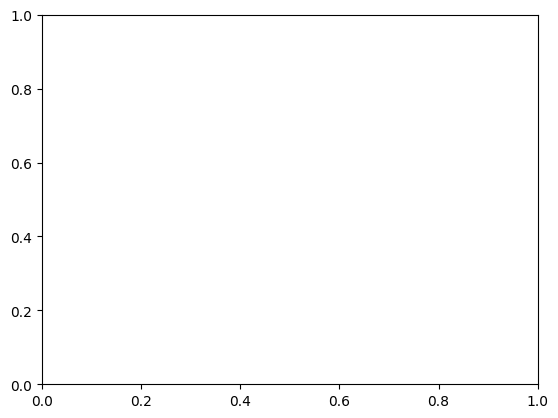

In [5]:
my_model.tracker.plot_loss()